# 6.2 Классификация.Фильмы

Для тех, кто хочет поставить точку в рекомендательных системах.

### Рекомендательная система и kNN

В прошлый раз мы использовали kMeans, тоже метрический алгоритм, но кластеризации, для построения "рекомендательной ситсемы". На самом деле тогда вы строили кластеры жанров/фильмов на основе предпочтений пользователей.  

Теперь попробуем kNN для рекомендаций. Мы построим модель, в которой не будет кластеров, но которая сможет выводить список наиболее похожих фильмов для заданного.

Подготовка датасета похожа на то, что мы уже делали. Отличаться будет только последний пункт, когда мы запустим kNN с косинусной метрикой.

Будем использовать известный нам [датасет с оценками фильмов](http://www.cs.umn.edu/GroupLens). Только в этот раз мы не будем кластеризовывать жанры, а будем рекомендовать похожие фильмы, основываясь на оценках других пользователей. То есть мы будем по факту предсказывать предпочтение нового пользователя на основе других.

Для рекомендательной системы в датасете в объектами будут пользователи, а признаками - оценки фильма данным пользователем.

![](https://i.imgur.com/hn3xjZl.png)

Мы будем использовать метрический алгоритм для поиска ближайших соседей, тем самым рекомендовать фильмы близкие к данному.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
movies = pd.read_csv('../../data/imdb_movies.csv.gz', index_col='movieId')
ratings = pd.read_csv('../../data/imdb_ratings.csv.gz')

print(movies.shape)
print(ratings.shape)

(9125, 2)
(100004, 4)


In [3]:
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


### 1.1 Поиск популярных фильмов (3 балла)

Среди всех фильмов есть не популярные, для которых выставлена 1-2 оценки. Такого количества данных не достаточно, поэтому нужно срезать много фильмов с маленьким числом отзывов.

Посчтитайте количество оценок для каждого фильма.

In [5]:
ratings.shape

(100004, 4)

In [6]:
ratings.groupby('movieId')['rating'].count()

movieId
1         247
2         107
3          59
4          13
5          56
         ... 
161944      1
162376      1
162542      1
162672      1
163949      1
Name: rating, Length: 9066, dtype: int64

Выведите сводную статистику по количеству оценок фильмов. (общее число фильмов, среднее количество оценок, дисперсию, квантили)

In [7]:
count_reviews = ratings.groupby('movieId')['rating'].count().rename('count_reviews').reset_index()
count_reviews[['count_reviews']].describe()

,count_reviews
count,9066.000000
mean,11.030664
std,24.050800
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,341.000000


Как мы видим `75%` квантиль показывет, что `75%` фильмов имело очень мало оценок. Нам столько будет недостаточно. Посчтитайте квантили в диапазоне от `75%` до `100%` с шагом в `1%`. Выберите тот квантиль, при котором количество оценок равно 20. Напишите какой это квантиль. Напишите сколько всего фильмов останется, если отбросить все фильмы у которых рейтинг меньше этого квантиля.

In [8]:
count_reviews_quantiles = count_reviews.quantile(np.arange(0, 1.01, 0.01))
count_reviews_quantiles[count_reviews_quantiles['count_reviews']==20]

,movieId,count_reviews
0.86,87303.4,20.0


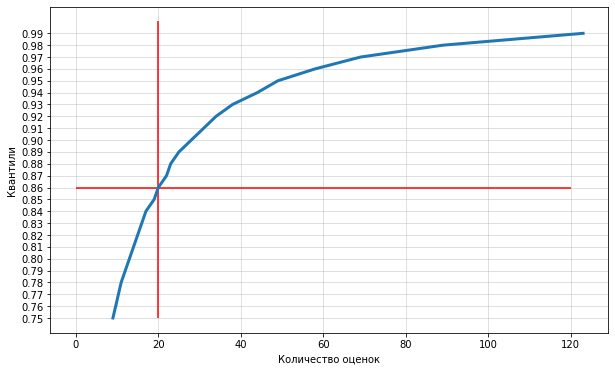

In [9]:
fsize = (10, 6)
fig, ax = plt.subplots(figsize=fsize)
sns.lineplot(ax=ax, x=count_reviews.quantile(np.arange(.75, 1, 0.01))['count_reviews'], y=np.arange(.75, 1, 0.01), lw=3)
plt.hlines(0.86, 0, 120, color = 'r')
plt.vlines(20, 0.75, 1, color = 'r')
plt.grid(alpha=0.5)
ax.set_xlabel('Количество оценок')
ax.set_ylabel('Квантили')
plt.yticks(np.arange(0.75, 1, 0.01))
pass

In [10]:
#Беру ИД фильмов, соответствующих нашему условию
movieid_gt20 = count_reviews[count_reviews['count_reviews']>=20]['movieId'].values
movieid_gt20

array([     1,      2,      3, ..., 122886, 134130, 134853])

In [11]:
ratings_gt20=ratings[ratings['movieId'].isin(movieid_gt20)]
ratings_gt20

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99996,671,5991,4.5,1064245387
99997,671,5995,4.0,1066793014
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [12]:
print('Всего уникальных фильмов: {}\nУникальных фильмов с количеством оценок более 20 шт: {}\n'.format(count_reviews['movieId'].count(), len(movieid_gt20)))
print('Всего записей по оценкам фильмов: {}\nЗаписей по фильмам с количеством оценок более 20 шт: {}'.format(ratings.shape[0], ratings_gt20.shape[0]))


Всего уникальных фильмов: 9066
Уникальных фильмов с количеством оценок более 20 шт: 1303

Всего записей по оценкам фильмов: 100004
Записей по фильмам с количеством оценок более 20 шт: 69104


### 1.2 Соединяем таблицы (1 балл)

Будет немного не удобно искать фильмы по их идентификаторам, нам нужны названия. Поэтому соедините две таблицы `ratings` и `movies` по `movieId` и отфильтруйте отзывы на редкие фильмы, которые мы нашли в предыдущем шаге. Выведите первые 5 элементов полученного датасета.

In [13]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [14]:
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [15]:
movies_gt20=movies.loc[movieid_gt20]
movies_gt20

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
5,Father of the Bride Part II (1995),Comedy
6,Heat (1995),Action|Crime|Thriller
...,...,...
116797,The Imitation Game (2014),Drama|Thriller|War
122882,Mad Max: Fury Road (2015),Action|Adventure|Sci-Fi|Thriller
122886,Star Wars: Episode VII - The Force Awakens (2015),Action|Adventure|Fantasy|Sci-Fi|IMAX


In [16]:
films = ratings_gt20.join(movies_gt20,lsuffix='_duble',on='movieId',how='left')
films.head()

,userId,movieId,rating,timestamp,title,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller
3,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama


In [17]:
films.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69104 entries, 0 to 100003
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     69104 non-null  int64  
 1   movieId    69104 non-null  int64  
 2   rating     69104 non-null  float64
 3   timestamp  69104 non-null  int64  
 4   title      69104 non-null  object 
 5   genres     69104 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 3.7+ MB


### 1.3 Матрица Фильмы-Пользователи

В нашем случае мы будем искать похожие фильмы, поэтому сделайте из датасета оценок матрицу, где в строках фильмы, в колонках пользователи, а в ячейках оценки. Пропущенные значение, то есть отсутсвие оценки, заполните 0.

Для увеличения скорости выполнения алгоритма ближайших соседей примените функцию [`scipy.sparse.csc_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html),  которая создаст плотное представление нашей разреженой матрицы.

In [18]:
films.shape

(69104, 6)

In [19]:
films_pivot = pd.pivot_table(films, values=['rating'], columns=['userId'], index=['movieId'], fill_value=0)
films_pivot

rating                                          ...                    \
userId     1   2    3   4    5    6   7    8   9   10   ... 662  663  664 665   
movieId                                                 ...                     
1          0.0   0  0.0   0  0.0  0.0   3  0.0   4   0  ...   0  4.0  3.5   0   
2          0.0   0  0.0   0  0.0  0.0   0  0.0   0   0  ...   5  0.0  0.0   3   
3          0.0   0  0.0   0  4.0  0.0   0  0.0   0   0  ...   0  0.0  0.0   3   
5          0.0   0  0.0   0  0.0  0.0   0  0.0   0   0  ...   0  0.0  0.0   3   
6          0.0   0  0.0   0  0.0  0.0   0  0.0   0   0  ...   0  0.0  4.0   0   
...        ...  ..  ...  ..  ...  ...  ..  ...  ..  ..  ...  ..  ...  ...  ..   
116797     0.0   0  0.0   0  0.0  0.0   0  0.0   0   0  ...   0  0.0  4.0   0   
122882     0.0   0  0.0   0  0.0  0.0   0  0.0   0   0  ...   0  4.0  4.0   0   
122886     0.0   0  0.0   0  0.0  0.0   0  0.0   0   0  ...   0  0.0  0.0   0   
134130     0.0   0  0.0   0  0.0  0.0   0  0.0   0   0  ...   0  0.0  0.0   0   
134853     0.0   0  0.0   0  0.0  0.0   0  0.0   0   0  ...   0  4.0  0.0   0   

                                  
userId  666 667 668 669 670  671  
movieId                           
1         0   0   0   0   4  5.0  
2         0   0   0   0   0  0.0  
3         0   0   0   0   0  0.0  
5         0   0   0   0   0  0.0  
6         5   4   0   0   0  0.0  
...      ..  ..  ..  ..  ..  ...  
116797    0   0   0   0   0  0.0  
122882    0   0   0   0   0  0.0  
122886    0   0   0   0   0  0.0  
134130    0   0   0   0   0  0.0  
134853    0   0   0   0   0  0.0  

[1303 rows x 671 columns]

In [20]:
films_pivot.shape

(1303, 671)

In [21]:
len(films.movieId.unique())

1303

### 1.4 Тренировка модели рекомендаций 

Так как по сути у нас нет каких-то меток классов, мы будем использовать алгоритма без учителя [`sklearn.neighbors.NearestNeighbors`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html). Научите его по данным нашей матрицы пользователей-фильмов и напишите **функцию**, принимающую на вход название фильма и возвращающую список из 6 рекомендованых фильмов, начиная от более похожего.

Для определения "похожести" двух фильмов мы будем использовать косинусную меру, вместо евклидова или минковского:

$$\LARGE cos(\overrightarrow{x},\overrightarrow{y}) = \frac{\overrightarrow{x} \cdot \overrightarrow{y}}{||\overrightarrow{x}|| \times ||\overrightarrow{y}||}$$

In [25]:
from sklearn.neighbors import NearestNeighbors

In [26]:
neigh = NearestNeighbors(6, 0.4, metric='cosine')
neigh.fit(films_pivot)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                 radius=0.4)

In [27]:
distances, indices = neigh.kneighbors()

In [28]:
distances #Расстояние до ближайщих 6 объектов

array([[0.40529019, 0.42381215, 0.43546614, 0.4370544 , 0.45197698,
        0.46329971],
       [0.45365212, 0.46964298, 0.49416945, 0.50539472, 0.50587601,
        0.50600542],
       [0.49414416, 0.5295131 , 0.5472295 , 0.56308386, 0.56435223,
        0.57468361],
       ...,
       [0.42609211, 0.44893893, 0.46483801, 0.4667377 , 0.4760689 ,
        0.48848997],
       [0.3242834 , 0.4667377 , 0.49079899, 0.4927216 , 0.55125827,
        0.55800733],
       [0.50075288, 0.54598048, 0.57852791, 0.59227865, 0.59932558,
        0.60165035]])

In [29]:
indices # Индексы ближайщих 6 объектов

array([[ 816,   99,  137,  240,  407,  411],
       [ 181,  141,  121,  142,  211,  205],
       [ 248,  228,  179,  245,    5,  240],
       ...,
       [1295, 1292, 1268, 1301, 1288, 1235],
       [1288, 1300, 1299, 1297, 1283, 1234],
       [1299, 1296, 1297, 1288, 1289, 1301]])

In [30]:
# Возвращает название фильма по ИД или ИД фильма по названию
def GetMovieByNameOrId (NameOrId, revers=False, data=movies):
    out = ''
    if revers:
        out = data.loc[NameOrId]['title']
    else:
        out = data[data['title']==NameOrId].index[0]   
    return out 

In [31]:
# Возвращает 6 похожих фильмов
def similar(movie_name, data=films_pivot, n=6, r=0.4, metric='cosine'):
    neigh = NearestNeighbors(n, r, metric=metric)
    neigh.fit(data)
    movieId = GetMovieByNameOrId(movie_name)
    distances, indices = neigh.kneighbors(data.loc[[movieId]])
    out_movies = []
    for index in indices[0]:  
        name=GetMovieByNameOrId(data.index[index], revers=True) #indices = iloc
        out_movies.append(name)
    return out_movies  

Выведите рекомендации для фильмов:
- `Pulp Fiction (1994)`
- `Star Wars: Episode V - The Empire Strikes Back (1980)`
- `Lord of the Rings: The Two Towers, The (2002)`

In [32]:
similar('Pulp Fiction (1994)')

['Pulp Fiction (1994)',
 'Silence of the Lambs, The (1991)',
 'Shawshank Redemption, The (1994)',
 'Seven (a.k.a. Se7en) (1995)',
 'Forrest Gump (1994)',
 'Usual Suspects, The (1995)']

In [33]:
similar('Star Wars: Episode V - The Empire Strikes Back (1980)')

['Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
 'Indiana Jones and the Last Crusade (1989)',
 'Back to the Future (1985)']

In [34]:
similar('Lord of the Rings: The Two Towers, The (2002)')

['Lord of the Rings: The Two Towers, The (2002)',
 'Lord of the Rings: The Return of the King, The (2003)',
 'Lord of the Rings: The Fellowship of the Ring, The (2001)',
 'Pirates of the Caribbean: The Curse of the Black Pearl (2003)',
 'Matrix, The (1999)',
 'Spider-Man (2002)']

### 1.5 Как посчитать качество рекомендации?

Как посчитать качество нашей классификации? У нас нет учителя, нет отложенной выборки. Мы просто посчитали все рейтинги и на основе них сделали предположения о похожести товаров. 

А как вы думаете можно проверить качество нашей рекомендательной системы? Напишите развернутый ответ своими словами.

При рекомендации пользователям отслеживать какие оценки они ставят этим фильмам, если плохие, то рекомендация не верная. Т.е. можно взять исходный фильм и уникальных пользователей которые поставили оценки для этого фильма, и сравнить с оценками этих пользователей на рекомендованный фильм. Положительные оценки за исходный фильм и рекомендованный - хорошо, положительные за исходный и отрицательные за рекомендованный - штраф. Так же если за исходный фильм пользователь поставил плохую оценку а за рекомендованный хорошую, то тоже хорошо.

Можно ввести диапазон хорошей оценки пользователя, к примеру за исходный поставил 4, допустимое отклонение 0.5, за рекомендованный поставил 3.8, разница в 0.2, меньше допустимого 0.5 то сичтаем что рекомендация удачная.

Так же можно еще сравнивать жанры фильмов и года выпуска, возможно есть пользователи, которые предпочитают фильмы одного жанра или диапазона годов выпуска. 

![](https://69.media.tumblr.com/06a071083b3e62cd76f31af07ecb895f/tumblr_p49r4rWXG21uxovwqo1_540.gif)